## Computer Vision Final Project
## Shape Recognition Using HOG

### 1.0 Dependencies
 * Install  `OpenCV`  for Anaconda with the following command:  `conda install -c conda-forge opencv`
 * Install  `imutils`  with the following command:  `sudo pip install imutils`

In [1]:
import cv2
import os
import numpy as np
from random import shuffle
import imutils #need to install this with pip
import matplotlib.pyplot as plt
from skimage import data, color, exposure
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# displays graphs and images in cells instead of in a new window
%matplotlib inline

### 2.0 Helper Functions
 * The following functions help simplify some of the routines and have been collected into one cell
 * Make sure to run this cell again if you change anything
 * Non-max-suppression was found at https://www.pyimagesearch.com/2014/11/17/non-maximum-suppression-object-detection-python/

In [7]:
### helper functions

# load_positives loads each positive image, post-process them, and gets features using HOG
# returns a data set of features
def load_positives(hog, dims, count):
    pdata = []
    for i in range(1, count+1):
        path = "imgs/training_imgs/" + "{}".format(i).rjust(4, '0') + ".jpg"
        img = cv2.imread(path, 1)
        if img is not None:
            img = pre_process(img, dims)
            feat = hog.compute(img[:,:,:3])
            pdata.append((feat, 1))
    return pdata

# load_negatives loads each negative image, post-processes it, and gets features using HOG
# returns a data set of features
def load_negatives(hog, dims, count):
    ndata = []
    #nimages = []
    for i in range(1, count+1):
        path = "imgs/random_imgs/" + "{}".format(i).rjust(4, '0') + ".jpg"
        img = cv2.imread(path)
        if img is not None:
            img = pre_process(img, dims)
            feat = hog.compute(img[:,:,:3])
            ndata.append((feat, 0))
    return ndata

def pre_process(img, dims):
    temp = cv2.resize(img, dims)
    return temp

def preprocess(image, lower, upper):
    #boundary in bgr color scheme for opencv

    lower = np.array(lower, dtype="uint8")
    upper = np.array(upper, dtype="uint8")

    # find the colors within the specified boundaries and apply
    # the mask
    mask = cv2.inRange(image, lower, upper)
    output = cv2.bitwise_and(image, image, mask = mask)
    #This takes image[x] and image[x] when mask is 1 (that is, it leaves it alone),
    #otherwise it makes image[x] = 0.9 The effect in this case is just image and mask. 
    #This is applied to all 3 channels
    
    return output, mask

def transform_scale(factor, boxes):
    return [[int(x[0]*factor), int(x[1]*factor), int(x[2]*factor), int(x[3]*factor)] for x in boxes]

# auto_canny function to automatically tune canny's parameters
# taken from
# https://www.pyimagesearch.com/2015/04/06/zero-parameter-automatic-canny-edge-detection-with-python-and-opencv/
def auto_canny(img, sigma=0.33):
    # compute the median of the single channel pixel intensities
    v = np.median(img)
    
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(img, lower, upper)
    
    # return the edged image
    return edged

# non_max_suppresssion function to reduce overlapping bounding boxes
# taken from https://www.pyimagesearch.com/2014/11/17/non-maximum-suppression-object-detection-python/
# Felzenszwalb et al.
def non_max_suppression(boxes, overlapThresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []
 
    # initialize the list of picked indexes
    pick = []
 
    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = x1 + boxes[:,2]
    y2 = y1 + boxes[:,3]
 
    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
    
    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list, add the index
        # value to the list of picked indexes, then initialize
        # the suppression list (i.e. indexes that will be deleted)
        # using the last index
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        suppress = [last]
        
        # loop over all indexes in the indexes list
        for pos in range(0, last):
            # grab the current index
            j = idxs[pos]
 
            # find the largest (x, y) coordinates for the start of
            # the bounding box and the smallest (x, y) coordinates
            # for the end of the bounding box
            xx1 = max(x1[i], x1[j])
            yy1 = max(y1[i], y1[j])
            xx2 = min(x2[i], x2[j])
            yy2 = min(y2[i], y2[j])
 
            # compute the width and height of the bounding box
            w = max(0, xx2 - xx1 + 1)
            h = max(0, yy2 - yy1 + 1)
 
            # compute the ratio of overlap between the computed
            # bounding box and the bounding box in the area list
            overlap = float(w * h) / area[j]
 
            # if there is sufficient overlap, suppress the
            # current bounding box
            if overlap > overlapThresh:
                suppress.append(pos)
 
        # delete all indexes from the index list that are in the
        # suppression list
        idxs = np.delete(idxs, suppress)
 
    # return only the bounding boxes that were picked
    return boxes[pick]

# function to compute the biggest bounding box that includes all bounding boxes detected
def find_biggest_bounds(boxes, dims):
    min_x = dims[0]
    min_y = dims[1]
    width = 0
    height = 0
    
    for x, y, w, h in boxes:
        if x < min_x:
            min_x = x
            width = w
        if y < min_y:
            min_y = y
            height = h
            
    for x, y, w, h in boxes:
        if w*h<200: # ignore really small boxes
            continue
        if x > min_x and x+w > min_x+width:
            width += x+w-min_x-width
        if y > min_y and y+h > min_y+height:
            height += y+h-min_y-height
            
    return (min_x, min_y, width, height)

### 3.0 Data Loading and Processing/Training
 * This could take quite long so please be patient!
 * Specify the number of positive and negative images you would like to load
 * The loading functions will still take care of corrupted/null images so if you get less than the actual number you put in, that's why

In [3]:
minDim = 256
blockSize = (32,32)
blockStride = (16,16)
cellSize = (16,16)
nbins = 8

dims = (minDim, minDim)

hog = cv2.HOGDescriptor(dims, blockSize, blockStride, cellSize, nbins)

# load positive data
pdata = load_positives(hog, dims, 156)

# load negative data
ndata = load_negatives(hog, dims, 106)

data = pdata + ndata
shuffle(data)

feat, labels = map(list, zip(*data))
feat = [x.flatten() for x in feat]

sample_size = len(feat)
train_size = int(round(0.8*sample_size))

train_feat = np.array(feat[:train_size], np.float32)
test_feat = np.array(feat[train_size: sample_size], np.float32)
train_label = np.array(labels[:train_size])
test_label = np.array(labels[train_size:sample_size])

lsvm = svm.SVC(kernel='linear', C = 1.0, probability=True)
lsvm.fit(train_feat, train_label)

print("Training score:", lsvm.score(train_feat, train_label))

Training score: 1.0


In [4]:
# compute test accuracy
print("Test accuracy:", lsvm.score(test_feat, test_label))
y_pred = lsvm.predict(test_feat)
print(classification_report(test_label, y_pred))

# confusion matrix
confusion_matrix(y_pred, test_label)

Test accuracy: 0.961538461538
             precision    recall  f1-score   support

          0       0.94      0.94      0.94        18
          1       0.97      0.97      0.97        34

avg / total       0.96      0.96      0.96        52



array([[17,  1],
       [ 1, 33]])

### 4.0 Image Recognition Test
 * Change `test_img` to the path of the test image you would like to try
 * Recognition is done using Canny to find the edges and then contours are found using the built-in `find_contours()` function
 * Non-max-suppression is used to simplify displaying bounding boxes
 * A simple match/miss test is done on the final bounding boxes to see if the majority of the bounding boxes in the image were a match with the training data set

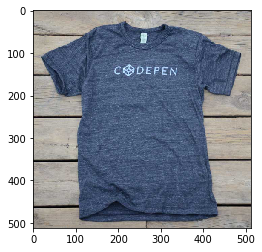

In [22]:
test_img = "imgs/shirt.jpg"

# load the test image in color
img = cv2.imread(test_img, 1)

# reduce size of image to avoid heavy computation
if img.shape[1] > 512:
    img = cv2.resize(img, (512, int(img.shape[0]*512/img.shape[1])))

# show it just to make sure
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

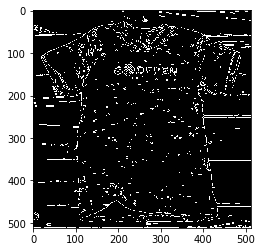

In [23]:
# pre_process this image the same way we did for the rest of our data
#binaryImg = pre_process(img, dims)
#binaryImg = cv2.cvtColor(binaryImg, cv2.COLOR_BGR2GRAY)
filtered = cv2.bilateralFilter(img, 25, 25, 25)
binaryImg = auto_canny(filtered)

# show the result of pre_processing
plt.imshow(binaryImg, cmap='gray')
plt.show()

In [24]:
im2, contours, hierarchy = cv2.findContours(binaryImg,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)

750
0 0 512 512


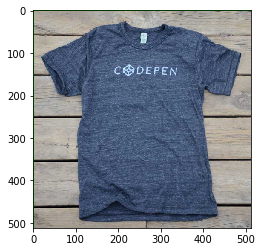

In [25]:
copy = img.copy()
#copy = cv2.bitwise_not(im)
rgb = cv2.cvtColor(copy, cv2.COLOR_BGR2RGB)

boxes = [cv2.boundingRect(c) for c in contours]
print(len(boxes))
x,y,w,h = find_biggest_bounds(boxes, (img.shape[0], img.shape[1]))
print(x,y,w,h)

cv2.rectangle(rgb, (x,y),(x+w, y+h), (0, 255, 0), 2)
plt.imshow(rgb)
plt.show()

 * We then compute HOG only for what's inside the bounding box
 * Also showing whether our trained SVM "thinks" it is a coffee cup or not

In [26]:
copy = img[y:y+h, x:x+w, :3]
#copy = img.copy()
copy = pre_process(copy, dims)
feat = hog.compute(copy)
prob = lsvm.predict_proba(feat.reshape(1,-1))[0]
print("Probability of this being a coffee cup is %0.2f percent" % (prob[1] * 100))

Probability of this being a coffee cup is 1.62 percent
